Comments:

- Feature engineer the temporal data (patient_nbr and encounter_id) to keep temporal information in the data (which we'll later use for LSTM NN model.
- Make plots readable
- Perform some inputation with clustering or bucketing for missing values
- Reorganaize the sections to have clearly defined Data Cleaning, Feaature Engineering, Feature selection, Normalization, etc.
- Check whether it makes sense to do a LASSO regularizataion on the Logistic Regression to sleect features and then stick with the selected features for other models too (I am pretty sure it does not make 100% sense)
- Implement SHAP for feature selection (might need to be working jointly with models.ipynb)


Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Data Transformation and Exploration.


This assignment asks you to predict readmission for diabetic patients admitted to hospital, i.e., what is the likelihood that a patient will need to come back to hospital given the data about this visit. 
This is based on a database of 101766 hospital visits with a set of 50 features covering patient information, treatment and prescribed medication during the hospital stay.
The database covers patients admitted to 130 hospitals in the US over a period of 10 years to 2008. The original data came from this source:

We decided to drop the following variables:

    'encounter_id',(TO KEEP for temporal information!)
    'patient_nbr', (TO KEEP for temporal information!)
    'payer_code',
    'medical_specialty',
    'weight',
    
For the time being, we remove the 2% missing values for "race" (which we could later inpute using clustering tecniques)

Intuitively, we can assume that all these datapoints have no incidence on the readmission because they are either abstract values arbitrarily set by humans (e.g. patinet_nbr) OR not directly related to the outcome of "readmission (e.g. "admission_source_id").

    We have decided to keep 1)'admission_type_id' and 2)'discharge_disposition_id' though they could have been droped because 
    
    1) We assume that different hospitals are exhibiting different levels of healthcare services (some better than others) 
    
    2) We assume that being sent back home can exhibit higher chances of readmission than being transfered to another hospital, in which patients are constantly monitored. 


Loading data

In [2]:
df_train = pd.read_csv("Dataset/diabetic_data_training.csv")
df_test = pd.read_csv('Dataset/diabetic_data_test.csv')

display(df_train.shape, df_test.shape)

(91589, 50)

(10177, 50)

First of all, in order to know whether we should remove patient_nbr from our feeatures, which at first seens irrelevant to predicting the readmission variable, we need to check if it is repeated.
We want to check in the data whether some patients have been readmitted more than once. If so, there is a temporal dimension hidden in the data, which is important information.  

In [3]:
# # check if there are some patient_id s that are repeated, meaning someone is readmitted more than once.
# print(df_train['patient_nbr'].value_counts())

Phew! That was a close call! We will keep it for now. 

We assign textual values to the numerical placeholders in the dataset communicated as we might perform some NLP

### Data Mapping and Dictionary Creation

This code performs **data mapping** (data preprocessing) by reading a CSV file (`IDS_mapping.csv`) that contains mappings of categorical or numerical IDs to their corresponding descriptions. The goal is to create a structured dictionary for each type of ID, which can later be used to translate numerical values in the main dataset into human-readable labels.

#### Key Objectives:
- **Interpretability:** Replace numerical or categorical IDs (e.g., `1`, `2`) with descriptive labels (e.g., "Emergency", "Urgent").
- **Data Enrichment:** Organize ID mappings into dictionaries for efficient lookup and transformation.
- **Data Cleaning:** Remove empty rows from the mapping CSV to ensure only relevant mappings are processed.

#### How the Code Works:
1. **Read the Mapping File:**
   - The mapping file is loaded into a Pandas DataFrame.
   
2. **Drop Empty Rows:**
   - Rows with all `NaN` values are removed to ensure clean data.

3. **Initialize Dictionary Structure:**
   - A dictionary (`dictionaries`) is created to store mappings for each category (e.g., `admission_type_id`).

4. **Iterate Over Rows:**
   - If a row starts with a numeric ID, the value is stored in the current category's dictionary.
   - If the row starts with a new category (non-numeric), the code recognizes it as a new section and initializes a new dictionary.

5. **Result:**
   - The final output is a nested dictionary where each category (like `admission_type_id`) contains mappings of IDs to their descriptive labels.


In [4]:
mapping_csv = pd.read_csv("Dataset/IDS_mapping.csv")
mapping_csv = mapping_csv.dropna(how='all')
dictionaries = {}
current_dict = 'admission_type_id'
dictionaries[current_dict] = {}


for index, row in mapping_csv.iterrows():
   id = row.to_list()[0]
   if id.isdigit():
       dictionaries[current_dict][row.to_list()[0]] = str(row.to_list()[1])
   else:
       current_dict = id
       dictionaries[current_dict] = {}

### Mapping Placeholder Values to Descriptive Labels in Train and Test Data

This code applies the previously created dictionaries to replace categorical placeholder values (`admission_type_id`, `discharge_disposition_id`, `admission_source_id`) in the training (`df_train`) and testing (`df_test`) datasets with their corresponding human-readable labels. This process enhances data interpretability and prepares the dataset for further analysis or modeling.

---

### How the Code Works:
1. **Conditional Mapping by Column Presence:**
   - The code checks if the above mentioned categorical columns exist in the DataFrame.
   - If the column is present, the `.map()` function is used to replace the placeholder values with their descriptive labels by referring to the `dictionaries` object created earlier.

2. **Mapping Process:**
   - The IDs in each column are cast to string format using `.astype(str)`, ensuring compatibility with the dictionary keys.
   - The `.map()` function performs the replacement by looking up the corresponding value from the appropriate dictionary (e.g., `dictionaries['admission_type_id']`).

---

### Why This is Important:
- **Improves Interpretability:**
   - The numeric or categorical IDs in the dataset are difficult to interpret directly. By mapping them to descriptive labels, the dataset becomes more readable and helps in exploratory data analysis and model interpretation.
- **Prevents Errors:**
   - By conditionally applying the mapping, we avoid errors that could occur if a column is missing from the DataFrame.
- **Facilitates Visualization and Reporting:**
   - Descriptive labels make charts, graphs, and summaries easier to understand and present to stakeholders.

In [5]:
# Mapping the textual values associated with teh placeholder values given originally in teh dataset

# TRAIN DATA

if 'admission_type_id' in df_train.columns:
   df_train['admission_type_id'] = df_train['admission_type_id'].astype(str).map(dictionaries['admission_type_id'])


# Map discharge dispositions
if 'discharge_disposition_id' in df_train.columns:
   df_train['discharge_disposition_id'] = df_train['discharge_disposition_id'].astype(str).map(dictionaries['discharge_disposition_id'])


if 'admission_source_id' in df_train.columns:
   df_train['admission_source_id'] = df_train['admission_source_id'].astype(str).map(dictionaries['admission_source_id'])
   
# TEST DATA

if 'admission_type_id' in df_test.columns:
   df_test['admission_type_id'] = df_test['admission_type_id'].astype(str).map(dictionaries['admission_type_id'])


# Map discharge dispositions
if 'discharge_disposition_id' in df_test.columns:
   df_test['discharge_disposition_id'] = df_test['discharge_disposition_id'].astype(str).map(dictionaries['discharge_disposition_id'])


if 'admission_source_id' in df_test.columns:
   df_test['admission_source_id'] = df_test['admission_source_id'].astype(str).map(dictionaries['admission_source_id'])
   
display(df_train.head(10), df_test.head(10), df_train.shape, df_test.shape)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,Emergency,Discharged to home,Emergency Room,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,Emergency,Discharged to home,Emergency Room,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,Emergency,Discharged to home,Emergency Room,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,Emergency,Discharged to home,Emergency Room,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,Urgent,Discharged to home,Clinic Referral,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
5,55842,84259809,Caucasian,Male,[60-70),?,Elective,Discharged to home,Clinic Referral,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,63768,114882984,Caucasian,Male,[70-80),?,Emergency,Discharged to home,Emergency Room,5,...,No,No,No,No,No,No,No,No,Yes,>30
7,12522,48330783,Caucasian,Female,[80-90),?,Urgent,Discharged to home,Transfer from a hospital,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
8,15738,63555939,Caucasian,Female,[90-100),?,Elective,Discharged/transferred to SNF,Transfer from a hospital,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,36900,77391171,AfricanAmerican,Male,[60-70),?,Urgent,Discharged to home,Transfer from a hospital,7,...,No,Steady,No,No,No,No,No,Ch,Yes,<30


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,nan,Not Mapped,Physician Referral,1,...,No,No,No,No,No,No,No,No,No,NO
1,28236,89869032,AfricanAmerican,Female,[40-50),?,Emergency,Discharged to home,Emergency Room,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
2,150006,22864131,?,Female,[50-60),?,Urgent,Discharged to home,Transfer from a hospital,2,...,No,Down,No,No,No,No,No,Ch,Yes,NO
3,253380,56480238,AfricanAmerican,Female,[60-70),?,Emergency,Discharged to home,Emergency Room,6,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,383430,80588529,Caucasian,Female,[70-80),?,Emergency,Discharged/transferred to another short term h...,Emergency Room,1,...,No,Down,No,No,No,No,No,Ch,Yes,>30
5,550098,21820806,AfricanAmerican,Male,[50-60),?,Urgent,Discharged to home,Clinic Referral,4,...,No,No,No,No,No,No,No,No,No,<30
6,676422,63754317,AfricanAmerican,Female,[70-80),?,Emergency,Discharged to home,Emergency Room,4,...,No,Steady,No,No,No,No,No,No,Yes,>30
7,870294,95075649,Caucasian,Female,[70-80),?,Emergency,Discharged/transferred to home with home healt...,Emergency Room,7,...,No,No,No,No,No,No,No,No,No,<30
8,1072554,114039603,Caucasian,Male,[70-80),?,Elective,Discharged to home,Clinic Referral,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,1161024,20830941,Caucasian,Female,[70-80),?,Emergency,Discharged/transferred to another short term h...,Emergency Room,5,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


(91589, 50)

(10177, 50)

### Dropping Unnecessary Columns from Train and Test Data

Here, we do some **data cleaning** and remove specific columns from the training (`df_train`) and testing (`df_test`) datasets to streamline the data and eliminate some features that are not useful for modeling or analysis.

### Key Objectives:
- **Feature Reduction:** Drop columns that do not contribute to predictive power or model performance.
- **Focus on Relevant Features:** Remove columns that may introduce noise, redundancy, or irrelevant information (e.g., identifiers like `encounter_id` or `patient_nbr`).

In [6]:
# CREATION OF df_train_ and df_test_ dataframes, which are simply dropping the columns below
features_to_drop = ['payer_code', 'medical_specialty', 'weight'] # remove 'encounter_id', 'patient_nbr' to keep temporal information

print("Number of columns in df_train_ before dropping:", len(df_train.columns))
print("Number of columns in df_test_ before dropping:", len(df_test.columns))
print("\n")

# # Drop columns directly from both dataframes
df_train_ = df_train.drop(columns=features_to_drop, axis=1)
df_test_ = df_test.drop(columns=features_to_drop, axis=1)

# Print the number of columns remaining
print("Number of columns in df_train_ after dropping:", len(df_train_.columns))
print("Number of columns in df_test_ after dropping:", len(df_test_.columns))


Number of columns in df_train_ before dropping: 50
Number of columns in df_test_ before dropping: 50


Number of columns in df_train_ after dropping: 47
Number of columns in df_test_ after dropping: 47


### Replacing Missing Values

This code carries out more **data cleaning** and replaces all instances of the placeholder value `'?'` in the training (`df_train`) and testing (`df_test`) datasets with `NaN` (Not a Number), which is the standard representation for missing values in Pandas. 
We also replace missing or placeholder values (`None` or `'none'`) in two specific columns (`max_glu_serum` and `A1Cresult`) in the training dataset (`df_train`) with a more descriptive string:  
**"The test was not conducted on this patient"**.

---

### Key Objectives:
- **Handle Missing Data:** Convert non-standard missing value indicators (`?`) to a format (`NaN`) that can be recognized and processed by Pandas' data manipulation functions.
- **Improve Data Interpretability:** Rather than leaving ambiguous values like `'none'` or `None`, this code replaces them with a clear, descriptive label that specifies why the value is missing.
- **Standardize Missing Values:** Ensures that different forms of missing values (`None` vs `'none'`) are treated consistently.
- **Ensure Consistency:** Standardize the representation of missing values across the dataset, making it easier to apply imputation or filtering techniques.


In [7]:

# Generate Timestep for Each Patient (Visit Number)
df_train_['timestep'] = df_train_.groupby('patient_nbr').cumcount() + 1
df_test_['timestep'] = df_test_.groupby('patient_nbr').cumcount() + 1

# Reorder columns to place timestep as the 3rd column train dataset
columns = list(df_train_.columns)
columns.insert(2, columns.pop(columns.index('timestep')))
df_train_ = df_train_[columns]

# Select Relevant Columns (Keep Timestep)
#temporal_cols = [col for col in df_train_.columns]# if col not in ['readmitted']]
#df_train_ = df_train_[temporal_cols]


# Reorder columns to place timestep as the 3rd column test dataset
columns = list(df_test_.columns)
columns.insert(2, columns.pop(columns.index('timestep')))
df_test_ = df_test_[columns]

# Select Relevant Columns (Keep Timestep)
#temporal_cols = [col for col in df_test_.columns]# if col not in ['readmitted']]
#df_test_ = df_test_[temporal_cols]


In [8]:
# Replace '?' with NaN
df_train_ = df_train_.replace('?', pd.NA)
df_test_ = df_test_.replace('?', pd.NA)

# Replace None or 'none' values in the specified columns with the desired text
df_train_['max_glu_serum'] = df_train_['max_glu_serum'].replace(
    [None, 'none'], "The test was not conducted on this patient"
)
df_train_['A1Cresult'] = df_train_['A1Cresult'].replace(
    [None, 'none'], "The test was not conducted on this patient"
)

# Replace None or 'none' values in the specified columns with the desired text
df_test_['max_glu_serum'] = df_test_['max_glu_serum'].replace(
    [None, 'none'], "The test was not conducted on this patient"
)
df_test_['A1Cresult'] = df_test_['A1Cresult'].replace(
    [None, 'none'], "The test was not conducted on this patient"
)

print("Replacement completed for 'max_glu_serum' and 'A1Cresult'.")

Replacement completed for 'max_glu_serum' and 'A1Cresult'.


### Checking for Missing Values in the Training Data

This code checks for missing values in the `df_train` dataset and prints out only the features (columns) that contain missing data.

---

### Key Objectives:
- **Identify Missing Data:** Quickly detect which features have missing values. This will help with data quality assessment and imputation.
- **Focus on Relevant Features:** Print only the features with missing values to avoid unnecessary output and make the analysis more efficient.

In [9]:
# Checking for Missing Values and Printing Only Features with Missing Values
missing_values_df_train_ = df_train_.isnull().sum()
# Filter for features with missing values
missing_values_df_train_ = missing_values_df_train_[missing_values_df_train_ > 0]

missing_values_df_test_ = df_test_.isnull().sum()
# Filter for features with missing values
missing_values_df_test_ = missing_values_df_test_[missing_values_df_test_ > 0]

# Print the features with missing values
print("\nFeatures with Missing Values in df_train_:")
print(missing_values_df_train_)

print("\nFeatures with Missing Values in df_test_:")
print(missing_values_df_test_)


Features with Missing Values in df_train_:
race      2059
diag_1      21
diag_2     320
diag_3    1266
dtype: int64

Features with Missing Values in df_test_:
race      214
diag_2     38
diag_3    157
dtype: int64


In [10]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# First, let's handle categorical variables
# Create label encoders
label_encoders = {}
other_cols = []
columns_to_impute = ['race', 'diag_1', 'diag_2', 'diag_3']

# Function to encode and decode 
def encode_categorical(df, columns):
    df_encoded = df.copy()
    for col in columns:
        if df[col].dtype == 'object':  # If column is categorical
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder()
                # Fill NaN with a placeholder first
                df_encoded[col] = df_encoded[col].fillna('Missing')
                # Fit and transform
                df_encoded[col] = label_encoders[col].fit_transform(df_encoded[col])
    return df_encoded

def decode_categorical(df):
    df_decoded = df.copy()
    for col in columns_to_impute:
        if col in label_encoders:
            df_decoded[col] = label_encoders[col].inverse_transform(df_decoded[col].astype(int))
    return df_decoded

# Encode both training and test data
df_train_encoded = encode_categorical(df_train, columns_to_impute)

# Now apply KNN imputation
imputer = KNNImputer(n_neighbors=5)

# Fit and transform training data
df_train_imputed = pd.DataFrame(
    imputer.fit_transform(df_train_encoded[columns_to_impute]),
    columns=columns_to_impute,
    index=df_train_encoded.index
)

# Round the values since we're working with categorical data
for col in columns_to_impute:
    df_train_imputed[col] = df_train_imputed[col].round()

# Decode the imputed values back to categories
df_train_imputed_decoded = decode_categorical(df_train_imputed)

for col in df_train_:
    if col not in columns_to_impute:
        other_cols.append(col)
if other_cols:
    df_train_ = pd.concat([df_train_imputed_decoded, df_train_[other_cols]], axis=1)
print(df_train_)

                  race  diag_1  diag_2 diag_3  encounter_id  patient_nbr  \
0            Caucasian     276  250.01    255        149190     55629189   
1      AfricanAmerican     648     250    V27         64410     86047875   
2            Caucasian       8  250.43    403        500364     82442376   
3            Caucasian     197     157    250         16680     42519267   
4            Caucasian     414     411    250         35754     82637451   
...                ...     ...     ...    ...           ...          ...   
91584  AfricanAmerican  250.13     291    458     443847548    100162476   
91585  AfricanAmerican     560     276    787     443847782     74694222   
91586        Caucasian      38     590    296     443854148     41088789   
91587        Caucasian     996     285    998     443857166     31693671   
91588        Caucasian     530     530    787     443867222    175429310   

       timestep  gender      age admission_type_id  ... citoglipton insulin  \
0       

In [11]:
# drop the rows with missing values for now, in the df_train_ dataframe
df_train_ = df_train_.dropna()
print("\nShape of df_train_ after dropping rows with missing values:", df_train_.shape)


Shape of df_train_ after dropping rows with missing values: (91589, 48)


As we can see, two of our dataset features have a large number of missing values. 

These are:

max_glu_serum: Indicates the range of the result or if the test was not taken. Values: >200, >300, normal, and none if not measured.

A1Cresult: Indicates the range of the result or if the test was not taken. Values: >8 if the result was greater than 8%, >7 if the result was greater than 7% but less than 8%, normal if the result was less than 7%, and none if not measured.

The problem is that these two columns are mixing numerical values with categorical ones. COULD WE POTENTIALLY CONVERT ALL OF THESE INTO STRINGS AND EMBBED THEM? THEN ??


### Converting Age from Categorical to Numerical Values

This code transforms the `age` column in the training (`df_train`) and testing (`df_test`) datasets from categorical bins into representative numerical values. This process facilitates easier analysis and allows age to be treated as a continuous variable in modeling. 

---

### Key Objectives:
- **Numerical Representation:** Convert categorical age ranges into numerical values that approximate the midpoint of each range.
- **Enable Mathematical Operations:** Transforming categorical data into numerical form allows for statistical operations, visualization, and direct input into machine learning models.

This step is part of **data transformation** and **feature engineering**.

In [12]:
# convert age from categorical to numerical variable
age_mapping = {
       '[0-10)' : 5,
       '[10-20)' : 15,
       '[20-30)' : 25,
       '[30-40)' : 35,
       '[40-50)' : 45,
       '[50-60)' : 55,
       '[60-70)' : 65,
       '[70-80)' : 75,
       '[80-90)' : 85,
       '[90-100)' : 95,
}

df_train_['age'] = df_train_['age'].map(age_mapping)
df_test_['age'] = df_test_['age'].map(age_mapping)



### One-Hot Encoding of Categorical Variables

This code performs **one-hot encoding** on the categorical features in the training (`df_train`) and testing (`df_test`) datasets. One-hot encoding transforms categorical variables into binary columns, ensuring the dataset is in a format that machine learning models can process effectively.

---

### Key Objectives:
- **Convert Categorical Data to Numerical Format:** One-hot encoding replaces each unique category with a binary column (0 or 1).
- **Prepare Data for Modeling:** Many machine learning algorithms require numerical input, and categorical data must be transformed accordingly.

This step is part of **data transformation** and **feature engineering** to prepare the dataset for machine learning.


In [13]:
readmitted_col_df_train_ = df_train_['readmitted']
df_train_ = df_train_.drop(columns=['readmitted'], axis=1)

readmitted_col_df_test_ = df_test_['readmitted']
df_test_ = df_test_.drop(columns=['readmitted'], axis=1)

from cProfile import label
from sklearn.preprocessing import LabelEncoder

# make sure our readmnitted columns are containing on ly 0,1,and 2 for the three classes: <30, >30, and NO
label_encoder = LabelEncoder()

label_encoder.fit_transform(readmitted_col_df_train_)
df_train_target = label_encoder.transform(readmitted_col_df_train_)

label_encoder.fit_transform(readmitted_col_df_test_)
df_test_target = label_encoder.transform(readmitted_col_df_test_)

class_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
print("Mapping of classes to encoded values:", class_mapping)

# create a list with the categorical columns and one with the numerical columns
categorical_columns = df_train_.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df_train_.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical Columns in df_train_:\n", categorical_columns)
print("\nNumerical Columns in df_train_:\n", numerical_columns)

Mapping of classes to encoded values: {'<30': 0, '>30': 1, 'NO': 2}

Categorical Columns in df_train_:
 ['race', 'diag_1', 'diag_2', 'diag_3', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Numerical Columns in df_train_:
 ['encounter_id', 'patient_nbr', 'timestep', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


In [14]:
# hot-one encoding of all our categorical variables. 

df_train_cat = pd.get_dummies(df_train_[categorical_columns],drop_first=False) # we set drop_first=False because our readmission column takes three values which requires creating three columns
df_test_cat = pd.get_dummies(df_test_[categorical_columns],drop_first=False) # we set drop_first=False because our readmission column takes three values which requires creating three columns


### Selecting Numerical Features from Train and Test Datasets

This code extracts numerical columns from the training (`df_train`) and testing (`df_test`) datasets to create separate DataFrames (`df_train_num` and `df_test_num`) that contain only numerical variables.

---

### Key Objectives:
- **Isolate Numerical Features:** By selecting only numerical columns, the code separates continuous or discrete variables from categorical data.
- **Prepare for Modeling:** Machine learning algorithms often process numerical data differently from categorical data. Isolating numerical features facilitates easier scaling, normalization, and modeling.

This step is part of the **feature selection** and **data preprocessing** process.

In [15]:
# Select numerical columns for df_train
df_train_num = df_train_[numerical_columns]
# Select numerical columns for df_test
df_test_num = df_test_[numerical_columns]

### Concatenating Numerical and Categorical Features

This code combines the numerical, categorical, and target variables from the training (`df_train`) and testing (`df_test`) datasets into unified DataFrames (`df_train_concat` and `df_test_concat`). This prepares the data for modeling by ensuring all relevant features are in a single DataFrame.

---

### Key Objectives:
- **Create Complete Datasets:** The goal is to merge different types of features—numerical, categorical (one-hot encoded), and age—along with the target variable (`readmitted`) into a consolidated dataset.
- **Ensure Model Readiness:** By concatenating all features, the resulting DataFrame can be directly fed into machine learning algorithms.

This step is part of the **data preprocessing** and **feature engineering** workflow, finalizing the dataset for model training and evaluation.

In [16]:
# Now, we concatenate all types of variables together
df_train_ = pd.concat([df_train_num, df_train_cat], axis = 1)
df_test_ = pd.concat([df_test_num, df_test_cat], axis = 1)

print(df_train_.shape)
print(df_test_.shape)

display(df_train_,df_test_)

(91589, 2370)
(10177, 1539)


,encounter_id,patient_nbr,timestep,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,149190,55629189,1,15,3,59,0,18,0,0,...,False,True,True,False,True,False,True,False,False,True
1,64410,86047875,1,25,2,11,5,13,2,0,...,False,True,True,False,True,False,False,True,False,True
2,500364,82442376,1,35,2,44,1,16,0,0,...,False,True,True,False,True,False,True,False,False,True
3,16680,42519267,1,45,1,51,0,8,0,0,...,False,True,True,False,True,False,True,False,False,True
4,35754,82637451,1,55,3,31,6,16,0,0,...,False,True,True,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91584,443847548,100162476,2,75,3,51,0,16,0,0,...,False,True,True,False,True,False,True,False,False,True
91585,443847782,74694222,1,85,5,33,3,18,0,0,...,False,True,True,False,True,False,False,True,False,True
91586,443854148,41088789,3,75,1,53,0,9,1,0,...,False,True,True,False,True,False,True,False,False,True
91587,443857166,31693671,4,85,10,45,2,21,0,0,...,False,True,True,False,True,False,True,False,False,True


,encounter_id,patient_nbr,timestep,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glipizide-metformin_No,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,2278392,8222157,1,5,1,41,0,1,0,0,...,True,True,False,True,False,True,False,True,True,False
1,28236,89869032,1,45,9,47,2,17,0,0,...,True,True,False,True,False,True,False,True,False,True
2,150006,22864131,1,55,2,66,1,19,0,0,...,True,True,False,True,False,True,True,False,False,True
3,253380,56480238,1,65,6,87,0,18,0,0,...,True,True,False,True,False,True,True,False,False,True
4,383430,80588529,1,75,1,28,0,15,0,0,...,True,True,False,True,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10172,443266892,180189752,1,55,5,71,5,23,0,0,...,True,True,False,True,False,True,True,False,False,True
10173,443721236,38726739,1,75,3,57,4,11,0,0,...,True,True,False,True,False,True,False,True,True,False
10174,443778398,134647673,1,45,1,1,5,8,0,0,...,True,True,False,True,False,True,True,False,False,True
10175,443824292,138784172,2,85,3,31,2,24,0,0,...,True,True,False,True,False,True,True,False,False,True


As we can see, our train and test data frames have different lengths (number of cols), this is because we have one-hot encoded everything and the values taken by certain columns were different in the train and test sets. This comes from the given test set itself, which does not contain as many different observations that the train set. When testing our model we'll have to set all columns present in the train set but not test set equal to 0 since they cannot be tested. (natral imbalance...)

### Converting Binary Categorical Values to Numerical Format

This code replaces binary categorical values (`Yes`, `No`, `True`, `False`) in the concatenated train and test datasets with numerical values (`1` and `0`).

---

### Key Objectives:
- **Standardize Binary Data:** Convert textual and boolean binary values into integers to ensure consistency and simplify data interpretation.
- **Model Compatibility:** Machine learning models require numerical input. Replacing binary strings (`Yes/No`) and booleans (`True/False`) with `1` and `0` ensures the data can be processed directly.

This step is part of **data cleaning** and **preprocessing**, ensuring that all features are numerical and ready for model training.

In [17]:
# We still have some non-numerical binary values which we need to replace by zeros and ones. For all columns in the dataset, make sure that Yes, True are replaced by 1 and that No, False are replaced by 0. 

df_train_ = df_train_.replace({'Yes': 1, 'No': 0, True: 1, False: 0})
df_test_ = df_test_.replace({"yes":1, "No":0, True:1, False:0})

display(df_train_.head(), df_test_.head())


/var/folders/9v/91ylsyks64x80_d2p3zkltzc0000gn/T/ipykernel_56543/1900152082.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_ = df_train_.replace({'Yes': 1, 'No': 0, True: 1, False: 0})
/var/folders/9v/91ylsyks64x80_d2p3zkltzc0000gn/T/ipykernel_56543/1900152082.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_ = df_test_.replace({"yes":1, "No":0, True:1, False:0})


,encounter_id,patient_nbr,timestep,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,149190,55629189,1,15,3,59,0,18,0,0,...,0,1,1,0,1,0,1,0,0,1
1,64410,86047875,1,25,2,11,5,13,2,0,...,0,1,1,0,1,0,0,1,0,1
2,500364,82442376,1,35,2,44,1,16,0,0,...,0,1,1,0,1,0,1,0,0,1
3,16680,42519267,1,45,1,51,0,8,0,0,...,0,1,1,0,1,0,1,0,0,1
4,35754,82637451,1,55,3,31,6,16,0,0,...,0,1,1,0,1,0,0,1,0,1


,encounter_id,patient_nbr,timestep,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,glipizide-metformin_No,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,2278392,8222157,1,5,1,41,0,1,0,0,...,1,1,0,1,0,1,0,1,1,0
1,28236,89869032,1,45,9,47,2,17,0,0,...,1,1,0,1,0,1,0,1,0,1
2,150006,22864131,1,55,2,66,1,19,0,0,...,1,1,0,1,0,1,1,0,0,1
3,253380,56480238,1,65,6,87,0,18,0,0,...,1,1,0,1,0,1,1,0,0,1
4,383430,80588529,1,75,1,28,0,15,0,0,...,1,1,0,1,0,1,1,0,0,1


### Verifying Removal of Non-Numerical Values

This code checks if there are any remaining non-numerical columns in the concatenated training (`df_train_concat`) and testing (`df_test_concat`) datasets. The goal is to ensure that all features, except for the target variable, are in numerical format.

---

- **Confirm Numerical Data:** Verify that all features (except the target variable) are numerical.
- **Identify Remaining Non-Numerical Columns:** If any non-numerical columns remain, they will be listed for further transformation.

This step is part of the **data validation** and **data quality assurance** process, ensuring that the dataset is fully prepared for machine learning model development.

In [18]:
# # finally, let's make sure we got rid of all non-numerical values except the target var. 
# non_numerical_columns_train = df_train_.select_dtypes(exclude=['number']).columns.tolist()

# print("Non-numerical columns:", non_numerical_columns_train)

# non_numerical_columns_test = df_test_.select_dtypes(exclude=['number']).columns.tolist()

# print("Non-numerical columns:", non_numerical_columns_test)


### Feature Selection and Dimensionality Reduction

This code selects the most important features from the dataset through multiple techniques, ensuring the final dataset retains only the most informative features. This process enhances model performance, reduces overfitting, and speeds up training.

---
1. **Chi-Square Test:** Identify the features that have the strongest association with the target variable (`readmitted`).
2. **Lasso Regression (L1 Penalty):** Select features by shrinking less important ones to zero, retaining only the most significant.
3. **Principal Component Analysis (PCA):** Reduce dimensionality by transforming selected features into orthogonal components that capture maximum variance.

This process is part of **feature selection** and **dimensionality reduction** to prepare datasets for machine learning pipelines.

In [103]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [104]:
# # Assuming df is your DataFrame
# # Sort by 'patient_nbr' and 'timestep' to ensure proper cumulative calculations
# df = df_train_.sort_values(by=['patient_nbr', 'timestep'])

# # Step 1: Calculate cumulative sum of visits
# df['cumulative_visits'] = df.groupby('patient_nbr')['timestep'].cumsum()

# # Step 2: Calculate mean of remaining data for each patient
# def calculate_mean_remaining(group):
#     # Create a column for the mean of the remaining rows
#     numeric_columns = group.select_dtypes(include=['number']).columns  # Only apply to numeric columns
#     for col in numeric_columns:
#         group[f'{col}_mean_remaining'] = group[col][::-1].expanding().mean()[::-1]
#     return group

# # Apply the function to the grouped data
# df = df.groupby('patient_nbr').apply(calculate_mean_remaining)

# # Step 3: Drop the 'mean_remaining' columns for the first row of each group (since no future data exists)
# #for col in df.columns:
# #    if 'mean_remaining' in col:
# #        df[col] = df.groupby('patient_nbr')[col].shift(-1)

# # Step 3: Retain only the last record for each patient
# last_visits = df.groupby('patient_nbr').tail(1)

# # Step 4: Keep only relevant columns (original + cumulative + mean columns)
# columns_to_keep = ['patient_nbr', 'cumulative_visits'] + [col for col in df.columns if 'mean_remaining' in col]
# last_visits = last_visits[columns_to_keep]

# # Final DataFrame
# print(last_visits.head())

In [105]:
# # Step 1: Separate Temporal Columns
# temporal_columns = ['patient_nbr', 'encounter_id', 'timestep']
# temporal_train = df_train_[temporal_columns]
# temporal_test = df_test_[temporal_columns]


In [106]:
# Ensure test dataset has the same columns as training dataset
missing_cols = [col for col in df_train_.columns if col not in df_test_.columns]
extra_cols = [col for col in df_test_.columns if col not in df_train_.columns]

# Add missing columns with zeros to test data
for col in missing_cols:
    df_test_[col] = 0

# Remove extra columns from test data
df_test_ = df_test_.drop(columns=extra_cols, errors='ignore')

print(df_test_.shape, df_train_.shape)

(10177, 2370) (91589, 2370)


In [107]:
# Ensure columns are in the same order as training data
df_test_ = df_test_[df_train_.columns]

# Verify shapes and column alignment
print("Training shape:", df_train_.shape)
print("Test shape:", df_test_.shape)
print("Columns identical:", all(df_train_.columns == df_test_.columns))

Training shape: (91589, 2370)
Test shape: (10177, 2370)
Columns identical: True


In [108]:
# Step 3: Min-Max Scaling for Chi-Square
minmax_scaler = MinMaxScaler()
X_train_minmax_scaled = minmax_scaler.fit_transform(df_train_)
X_test_minmax_scaled = minmax_scaler.transform(df_test_) 

print("Applying Chi-Square Test...")
# Initially fit with 'all' features to get scores
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_train_minmax_scaled, df_train_target)

# Get and sort Chi-Square scores
chi2_scores = pd.Series(chi2_selector.scores_, index=df_train_.columns).sort_values(ascending=False)

# Calculate cumulative explained contribution
cumulative_scores_chi2 = np.cumsum(chi2_scores) / chi2_scores.sum()

# Find optimal number of features
desired_contribution = 0.9
optimal_k_chi2 = np.argmax(cumulative_scores_chi2 >= desired_contribution) + 1
print(f"Optimal number of features to retain from Chi-Square: {optimal_k_chi2}")

# Get top features
top_features_chi2 = chi2_scores.head(optimal_k_chi2).index.tolist()
print(f"Top {optimal_k_chi2} features selected by Chi-Square:\n", top_features_chi2)

# Now refit the selector with the optimal k
chi2_selector = SelectKBest(score_func=chi2, k=optimal_k_chi2)
X_train_chi2_selected = chi2_selector.fit_transform(X_train_minmax_scaled, df_train_target)
X_test_chi2_selected = chi2_selector.transform(X_test_minmax_scaled)  # Add this line

# Convert to DataFrame while maintaining feature names
X_train_chi2_selected = pd.DataFrame(X_train_chi2_selected, columns=top_features_chi2)
X_test_chi2_selected = pd.DataFrame(X_test_chi2_selected, columns=top_features_chi2)  # Add this line

Applying Chi-Square Test...
Optimal number of features to retain from Chi-Square: 829
Top 829 features selected by Chi-Square:
 ['discharge_disposition_id_Expired', 'number_inpatient', 'discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital .', 'diag_1_428', 'discharge_disposition_id_Discharged/transferred to home with home health service', 'admission_source_id_ Transfer from another health care facility', 'timestep', 'admission_source_id_Transfer from a hospital', 'diag_2_250', 'diabetesMed_No', 'diag_2_403', 'admission_source_id_ Emergency Room', 'admission_type_id_Elective', 'diag_3_401', 'insulin_Down', 'discharge_disposition_id_Hospice / medical facility', 'diag_3_250', 'diag_1_V58', 'discharge_disposition_id_Discharged to home', 'diag_2_401', 'diag_3_585', 'diag_1_491', 'discharge_disposition_id_Discharged/transferred to SNF', 'race_?', 'discharge_disposition_id_Hospice / home', 'diag_3_?', 'admission_type_id_nan', 'diag_3_403', '

In [94]:
# # Step 3: Min-Max Scaling for Chi-Square
# minmax_scaler = MinMaxScaler()
# X_train_minmax_scaled = minmax_scaler.fit_transform(df_train_)

# print("Applying Chi-Square Test...")
# chi2_selector = SelectKBest(score_func=chi2, k='all')  # Use 'all' to get scores for all features
# chi2_selector.fit(X_train_minmax_scaled, df_train_target)

# # Chi-Square scores and plot
# chi2_scores = pd.Series(chi2_selector.scores_, index=df_train_.columns).sort_values(ascending=False)

# # Cumulative explained contribution (Chi-Square)
# cumulative_scores_chi2 = np.cumsum(chi2_scores) / chi2_scores.sum()

# # Optimal number of features from Chi-Square
# desired_contribution = 0.95
# optimal_k_chi2 = np.argmax(cumulative_scores_chi2 >= desired_contribution) + 1
# print(f"Optimal number of features to retain from Chi-Square: {optimal_k_chi2}")

# top_features_chi2 = chi2_scores.head(optimal_k_chi2).index.tolist()
# print(f"Top {optimal_k_chi2} features selected by Chi-Square:\n", top_features_chi2)

# # Reduce dataset to Chi-Square selected features
# X_train_chi2_selected = pd.DataFrame(X_train_minmax_scaled, columns=df_train_.columns)[top_features_chi2]



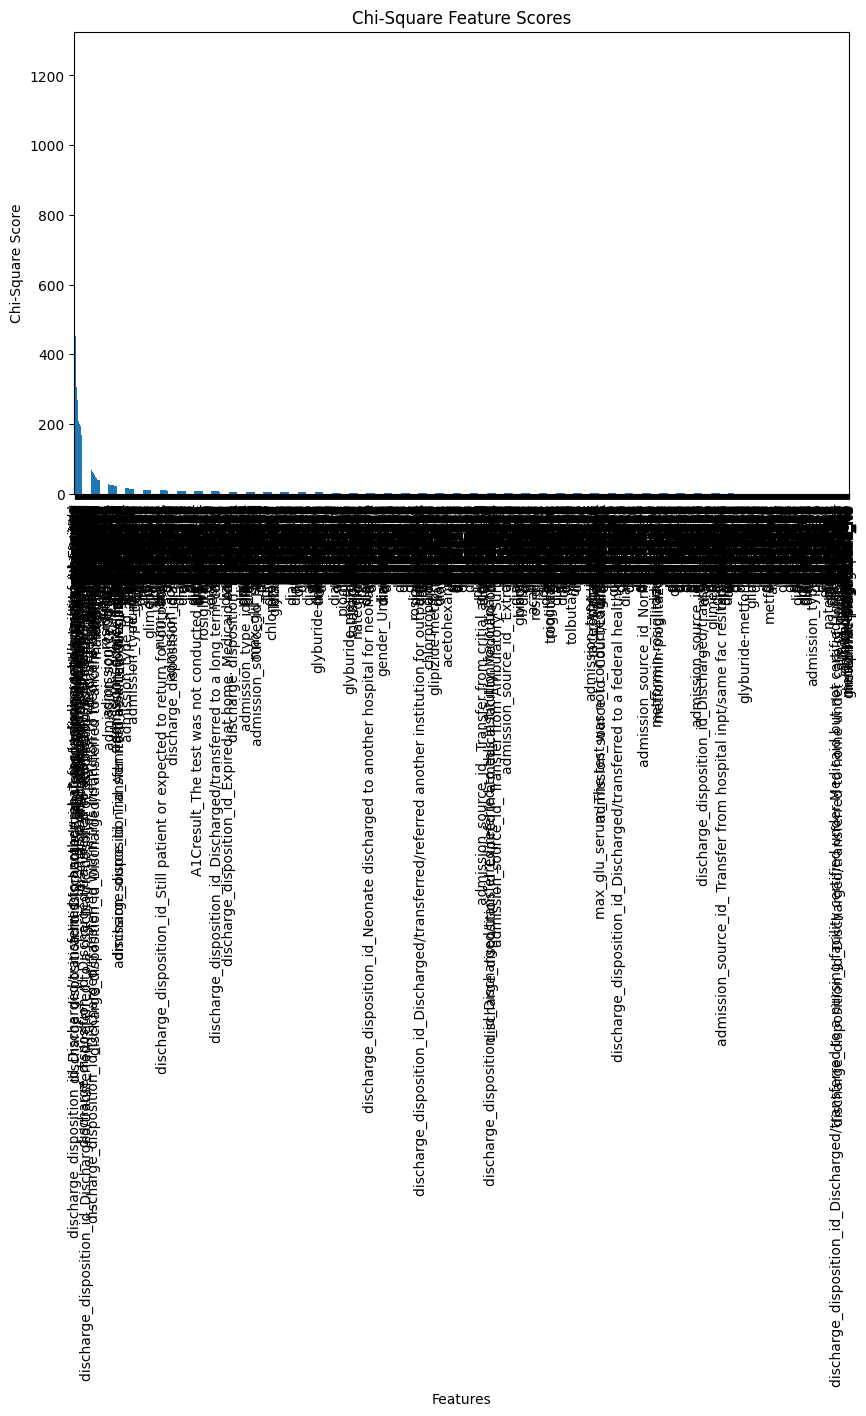

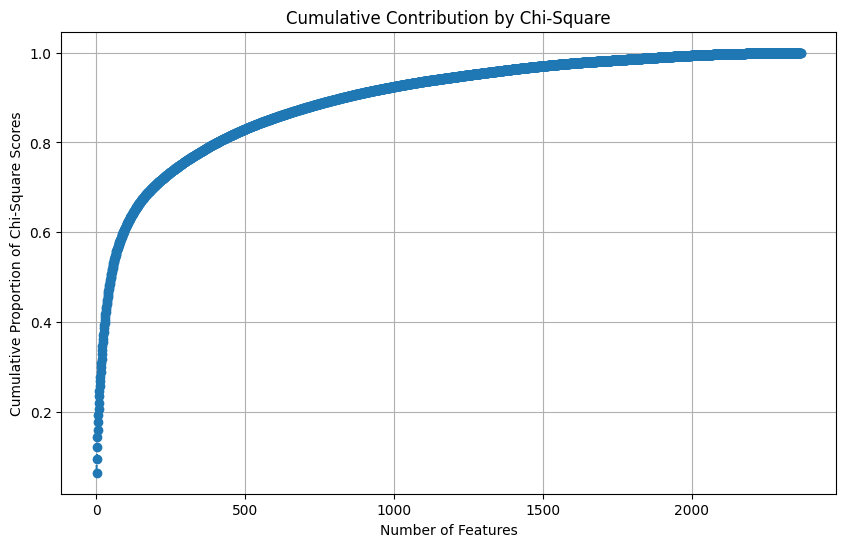

In [95]:
plt.figure(figsize=(10, 6))
chi2_scores.plot(kind='bar', title="Chi-Square Feature Scores")
plt.xlabel("Features")
plt.ylabel("Chi-Square Score")
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_scores_chi2) + 1), cumulative_scores_chi2, marker='o', linestyle='--')
plt.title('Cumulative Contribution by Chi-Square')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Proportion of Chi-Square Scores')
plt.grid()
plt.show()

In [96]:
print("Training shape:", X_train_chi2_selected.shape)
print("Test shape:", X_test_chi2_selected.shape)
print("Columns identical:", all(X_train_chi2_selected.columns == X_test_chi2_selected.columns))

Training shape: (91589, 1494)
Test shape: (10177, 1494)
Columns identical: True


In [97]:
print("Applying PCA...")
pca = PCA()  # Initialize PCA with all components
X_train_pca = pca.fit_transform(X_train_chi2_selected)

# Calculate cumulative explained variance
explained_variance_pca = np.cumsum(pca.explained_variance_ratio_)

# Find optimal number of components for desired variance (e.g., 95%)
desired_contribution = 0.99
optimal_k_pca = np.argmax(explained_variance_pca >= desired_contribution) + 1
print(f"Optimal number of PCA components to retain: {optimal_k_pca}")

# Create a DataFrame of explained variance by component
variance_df = pd.DataFrame({
    'Component': range(1, len(pca.explained_variance_ratio_) + 1),
    'Individual_Variance': pca.explained_variance_ratio_,
    'Cumulative_Variance': explained_variance_pca
})

print("\nTop 10 Components Explained Variance:")
print(variance_df.head(10).to_string(index=False))

# Refit PCA with optimal number of components
pca = PCA(n_components=optimal_k_pca)
X_train_final = pca.fit_transform(X_train_chi2_selected)
X_test_final = pca.transform(X_test_chi2_selected)

Applying PCA...
Optimal number of PCA components to retain: 595

Top 10 Components Explained Variance:
 Component  Individual_Variance  Cumulative_Variance
         1             0.107607             0.107607
         2             0.079318             0.186925
         3             0.062064             0.248990
         4             0.045325             0.294315
         5             0.040863             0.335178
         6             0.034047             0.369225
         7             0.026096             0.395320
         8             0.023994             0.419315
         9             0.022893             0.442208
        10             0.019869             0.462077


In [98]:
# # Perform PCA
# from sklearn.decomposition import PCA

# # Initialize PCA with the number of components you want
# # Let's say we want to keep enough components to explain 95% of variance
# print("Applying PCA...")
# pca = PCA(n_components=0.95)  

# # Fit and transform the data
# X_train_pca = pca.fit_transform(X_train_chi2_selected)
# X_test_pca = pca.transform(X_test_chi2_selected)



# print(X_train_pca.shape, X_test_pca.shape)


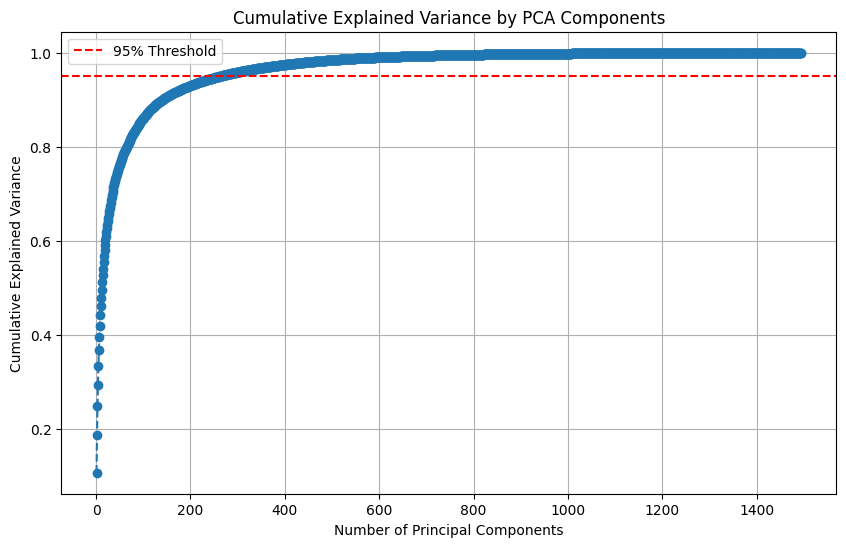

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_pca) + 1), explained_variance_pca, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.grid()
plt.show()

In [101]:
# import the clean data to run models in another notebook: 

import pickle

print(X_train_final.shape, X_test_final.shape, df_train_target.shape, df_test_target.shape)
# Save the data using pickle
with open("withpca_train_test_data.pkl", "wb") as f:
    pickle.dump((X_train_final, X_test_final, df_train_target, df_test_target), f)

(91589, 595) (10177, 595) (91589,) (10177,)


In [109]:
# import the clean data to run models in another notebook: 

import pickle

print(X_train_chi2_selected.shape, X_test_chi2_selected.shape, df_train_target.shape, df_test_target.shape)
# Save the data using pickle
with open("withoutpca_train_test_data.pkl", "wb") as f:
    pickle.dump((X_train_chi2_selected, X_test_chi2_selected, df_train_target, df_test_target), f)

(91589, 829) (10177, 829) (91589,) (10177,)


RUN THIS PART ONLY IF YOU INTEND TO USE AUTOML

In [183]:
y_train_encoded 

array([1, 2, 2, ..., 2, 2, 2])

In [184]:
y_test

0         NO
1        >30
2         NO
3         NO
4        >30
        ... 
10172    >30
10173     NO
10174     NO
10175    <30
10176    >30
Name: readmitted, Length: 10177, dtype: object

In [185]:
class_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
print("Mapping of classes to encoded values:", class_mapping)


Mapping of classes to encoded values: {'<30': 0, '>30': 1, 'NO': 2}


In [186]:
# Convert y_test to a NumPy array and drop the index
y_test = y_test.reset_index(drop=True).to_numpy().ravel()  # Ensure it's 1D

# Assuming label_encoder is already fitted
y_test_encoded = label_encoder.transform(y_test)  # Encode test target variable

# Verify the class mapping
class_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
print("Mapping of classes to encoded values:", class_mapping)

# Print encoded values of y_test
print("Encoded y_test:", y_test_encoded)

Mapping of classes to encoded values: {'<30': 0, '>30': 1, 'NO': 2}
Encoded y_test: [2 1 2 ... 2 0 1]


In [187]:
# import the clean data to run models in another notebook: 

import pickle

# Save the data using pickle
with open("train_test_data.pkl", "wb") as f:
    pickle.dump((X_train_final, X_test_final, y_train_encoded, y_test_encoded), f)